# Memory Optimized FinBERT Profiling: FP16 and AMP



Note: **AMP and FP16 are only enabled on CUDA by default** (to avoid MPS/CPU autocast edge cases).



## Imports
We import the necessary libraries and modules, including the custom `finbert` modules we have defined that allow for profiling.

In [1]:
from __future__ import annotations

from pathlib import Path
import shutil
import time
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import classification_report
from torch.nn import CrossEntropyLoss
from transformers import AutoModelForSequenceClassification

from finbert.finbert import *
from finbert.finbert_profile import *
from finbert.profile_utils import get_model_size_mb, print_device_info, setup_nltk_data
import finbert.utils as tools

import wandb

%load_ext autoreload
%autoreload 2

project_dir = Path.cwd().parent
pd.set_option('max_colwidth', None)

✓ Helper utilities loaded


In [2]:
# Paths
cl_path = project_dir / 'models' / 'mem_opt_comparison'
cl_path_baseline = project_dir / 'models' / 'mem_opt_comparison' / 'baseline'
cl_path_amp = project_dir / 'models' / 'mem_opt_comparison' / 'amp'
cl_data_path = project_dir / 'data' / 'sentiment_data'

# Clean up previous run
try:
    shutil.rmtree(cl_path)
except:
    pass

# # W&B
wandb.init(
    entity="si2449-columbia-university",
    project="Project-Runs",
    name="mem-opt-comparison",
    group="mem_optimization"
)

wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: Currently logged in as: tfs2123 (si2449-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
# Baseline (FP32) model and training
bertmodel_fp32 = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased', cache_dir=None, num_labels=3
)

config_baseline = Config(
    data_dir=cl_data_path,
    bert_model=bertmodel_fp32,
    num_train_epochs=6,
    model_dir=cl_path_baseline,  # Changed from cl_path
    max_seq_length=64,
    train_batch_size=32,
    learning_rate=0.00001420326287435756,
    output_mode='classification',
    warm_up_proportion=0.14386028719686458,
    local_rank=-1,
    discriminate=False,
    gradual_unfreeze=False,
    use_amp=False,  # Baseline uses FP32
)
config_baseline.profile_train_steps = 20

finbert_fp32 = ProfiledFinBert(config_baseline)
finbert_fp32.base_model = 'bert-base-uncased'
finbert_fp32.prepare_model(label_list=['positive', 'negative', 'neutral'])

train_data = finbert_fp32.get_data('train')
test_data = finbert_fp32.get_data('test')

model_fp32 = finbert_fp32.create_the_model()

# Train FP32
start = time.perf_counter()
trained_model_fp32 = finbert_fp32.train(train_examples=train_data, model=model_fp32)
baseline_train_wall_s = time.perf_counter() - start

# AMP model and training
bertmodel_amp = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased', cache_dir=None, num_labels=3
)

config_amp = Config(
    data_dir=cl_data_path,
    bert_model=bertmodel_amp,
    num_train_epochs=6,
    model_dir=cl_path_amp,  # Changed from cl_path
    max_seq_length=64,
    train_batch_size=32,
    learning_rate=0.00001420326287435756,
    output_mode='classification',
    warm_up_proportion=0.14386028719686458,
    local_rank=-1,
    discriminate=False,
    gradual_unfreeze=False,
    use_amp=True,  # Enable AMP
)
config_amp.profile_train_steps = 20

finbert_amp = ProfiledFinBert(config_amp)
finbert_amp.base_model = 'bert-base-uncased'
finbert_amp.prepare_model(label_list=['positive', 'negative', 'neutral'])

train_data = finbert_amp.get_data('train')
test_data = finbert_amp.get_data('test')

# train_data and test_data already loaded above
model_amp = finbert_amp.create_the_model()
    
# Train AMP
start = time.perf_counter()
trained_model_amp = finbert_amp.train(train_examples=train_data, model=model_amp)
amp_train_wall_s = time.perf_counter() - start


12/17/2025 03:25:14 - WARNING - torchao -   Skipping import of cpp extensions due to incompatible torch version 2.9.1+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
12/17/2025 03:25:17 - INFO - finbert.finbert -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False
12/17/2025 03:25:18 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:25:18 - INFO - finbert.utils -   guid: train-1
12/17/2025 03:25:18 - INFO - finbert.utils -   tokens: [CLS] after the reporting period , bio ##tie north american licensing partner so ##max ##on pharmaceuticals announced positive results with na ##lm ##efe ##ne in a pilot pha


Starting Profiled Training
Device: cuda
Profiling activities: [<ProfilerActivity.CPU: 0>, <ProfilerActivity.CUDA: 2>]



Epoch:   0%|          | 0/6 [00:06<?, ?it/s]



Profiling complete for first epoch (20 steps)
Continuing full training without profiling...


PROFILING RESULTS - Training


By CPU Time:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaStreamSynchronize        62.47%        4.792s        62.47%

Iteration: 100%|██████████| 109/109 [00:45<00:00,  2.41it/s]
12/17/2025 03:26:48 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:26:48 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:26:48 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:26:48 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:26:48 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:26:48 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6007370329820193]


Iteration: 100%|██████████| 109/109 [00:59<00:00,  1.83it/s]
12/17/2025 03:27:50 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:27:50 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:27:50 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:27:50 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:27:50 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:27:50 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6007370329820193, 0.5349188424073733]


Iteration: 100%|██████████| 109/109 [01:17<00:00,  1.40it/s]
12/17/2025 03:29:11 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:29:11 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:29:11 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:29:11 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:29:11 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:29:11 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6007370329820193, 0.5349188424073733, 0.5349188424073733]


Iteration: 100%|██████████| 109/109 [01:17<00:00,  1.41it/s]
12/17/2025 03:30:32 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:30:32 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:30:32 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:30:32 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:30:32 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:30:32 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6007370329820193, 0.5349188424073733, 0.5349188424073733, 0.5349188424073733]


Iteration: 100%|██████████| 109/109 [01:17<00:00,  1.41it/s]
12/17/2025 03:31:53 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:31:53 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:31:53 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:31:53 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:31:53 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:31:53 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6007370329820193, 0.5349188424073733, 0.5349188424073733, 0.5349188424073733, 0.5349188424073733]


Iteration: 100%|██████████| 109/109 [01:17<00:00,  1.41it/s]
12/17/2025 03:33:14 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:33:14 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:33:14 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:33:14 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:33:14 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:33:14 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6007370329820193, 0.5349188424073733, 0.5349188424073733, 0.5349188424073733, 0.5349188424073733, 0.5349188424073733]


Epoch: 100%|██████████| 6/6 [07:15<00:00, 72.50s/it]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
12/17/2025 03:33:20 - INFO - finbert.finbert -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False
12/17/2025 03:33:21 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:33:21 - INFO - finbert.utils -   guid: train-1
12/17/2025 03:33:21 - INFO - finbert.utils -   tokens: [CLS] after the reporting period , bio ##tie north american licensing partner so ##max ##on pharmaceuticals announced positive results with na ##lm ##efe ##ne in a pilot phase 2 clinical trial for smoking ce ##ssa ##tion [SEP]
12/17/2025 03:33:21 - INFO - finbert.utils -   input_ids: 101 2044 1996 7316 2558 1010 16012 9515 2167 2137 13202 4256 2061


Starting Profiled Training
Device: cuda
Profiling activities: [<ProfilerActivity.CPU: 0>, <ProfilerActivity.CUDA: 2>]



Epoch:   0%|          | 0/6 [00:05<?, ?it/s]



Profiling complete for first epoch (20 steps)
Continuing full training without profiling...


PROFILING RESULTS - Training


By CPU Time:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaStreamSynchronize        58.42%        3.891s        58.42%

Iteration: 100%|██████████| 109/109 [00:15<00:00,  7.22it/s]
12/17/2025 03:34:33 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:34:33 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:34:33 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:34:33 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:34:33 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:34:33 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.5174547663101783]


Iteration: 100%|██████████| 109/109 [00:17<00:00,  6.10it/s]
12/17/2025 03:34:53 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:34:53 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:34:53 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:34:53 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:34:53 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:34:53 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.5174547663101783, 0.4463546917988704]


Iteration: 100%|██████████| 109/109 [00:27<00:00,  3.96it/s]
12/17/2025 03:35:24 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:35:24 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:35:24 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:35:24 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:35:24 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:35:24 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.5174547663101783, 0.4463546917988704, 0.4463546917988704]


Iteration: 100%|██████████| 109/109 [00:27<00:00,  3.91it/s]
12/17/2025 03:35:55 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:35:55 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:35:55 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:35:55 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:35:55 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:35:55 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.5174547663101783, 0.4463546917988704, 0.4463546917988704, 0.4463546917988704]


Iteration: 100%|██████████| 109/109 [00:28<00:00,  3.88it/s]
12/17/2025 03:36:26 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:36:26 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:36:26 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:36:26 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:36:26 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:36:26 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.5174547663101783, 0.4463546917988704, 0.4463546917988704, 0.4463546917988704, 0.4463546917988704]


Iteration: 100%|██████████| 109/109 [00:21<00:00,  4.96it/s]
12/17/2025 03:36:51 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:36:51 - INFO - finbert.utils -   guid: validation-1
12/17/2025 03:36:51 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/17/2025 03:36:51 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:36:51 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:36:51 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.5174547663101783, 0.4463546917988704, 0.4463546917988704, 0.4463546917988704, 0.4463546917988704, 0.4463546917988704]


Epoch: 100%|██████████| 6/6 [02:35<00:00, 25.98s/it]


In [4]:
def timed_eval(*, finbert, model, examples, use_amp=False):
    """Evaluation with timing."""
    loader = finbert.get_loader(examples, phase="eval")
    device = finbert.device
    model.eval()
    
    preds, labels = [], []
    if device.type == "cuda":
        torch.cuda.synchronize(device)
    
    start = time.perf_counter()
    with torch.no_grad():
        for batch in loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, token_type_ids, label_ids, _ = batch
            
            if use_amp and device.type == "cuda":
                with torch.amp.autocast('cuda'):
                    logits = model(input_ids, attention_mask, token_type_ids)[0]
            else:
                logits = model(input_ids, attention_mask, token_type_ids)[0]
            
            preds.extend(logits.detach().cpu().numpy())
            labels.extend(label_ids.detach().cpu().numpy().tolist())
    
    if device.type == "cuda":
        torch.cuda.synchronize(device)
    
    wall_s = time.perf_counter() - start
    n = len(labels)
    
    return pd.DataFrame({"predictions": preds, "labels": labels}), {
        "eval_wall_s": wall_s,
        "eval_samples_per_s": n / wall_s if wall_s > 0 else float("inf"),
    }

def get_metrics(df):
    """Extract accuracy and F1 from eval results."""
    preds = np.array([np.argmax(p) for p in df['predictions']])
    labels = np.array(df['labels'])
    acc = (preds == labels).mean()
    from sklearn.metrics import f1_score
    f1 = f1_score(labels, preds, average='macro')
    return {"accuracy": acc, "f1_macro": f1}

# Evaluate baseline
baseline_eval_df, baseline_timing = timed_eval(finbert=finbert_fp32, model=trained_model_fp32, examples=test_data, use_amp=False)
baseline_metrics = get_metrics(baseline_eval_df)

print(f"Baseline - Accuracy: {baseline_metrics['accuracy']:.4f}, F1: {baseline_metrics['f1_macro']:.4f}")
print(f"Baseline - Throughput: {baseline_timing['eval_samples_per_s']:.1f} samples/sec")


amp_trained_eval_df, amp_trained_timing = timed_eval(
    finbert=finbert_amp, model=trained_model_amp, examples=test_data, use_amp=True
)
amp_trained_metrics = get_metrics(amp_trained_eval_df)
print(f"Trained AMP Model - Accuracy: {amp_trained_metrics['accuracy']:.4f}, F1: {amp_trained_metrics['f1_macro']:.4f}")
print(f"Trained AMP Model - Throughput: {amp_trained_timing['eval_samples_per_s']:.1f} samples/sec")

12/17/2025 03:36:55 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:36:55 - INFO - finbert.utils -   guid: test-1
12/17/2025 03:36:55 - INFO - finbert.utils -   tokens: [CLS] the bristol port company has sealed a one million pound contract with cooper specialised handling to supply it with four 45 - ton ##ne , custom ##ised reach stack ##ers from ko ##ne ##cr ##ane ##s [SEP]
12/17/2025 03:36:55 - INFO - finbert.utils -   input_ids: 101 1996 7067 3417 2194 2038 10203 1037 2028 2454 9044 3206 2007 6201 17009 8304 2000 4425 2009 2007 2176 3429 1011 10228 2638 1010 7661 5084 3362 9991 2545 2013 12849 2638 26775 7231 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:36:55 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:36:55 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Baseline - Accuracy: 0.7814, F1: 0.7695
Baseline - Throughput: 282.2 samples/sec
Trained AMP Model - Accuracy: 0.7814, F1: 0.7808
Trained AMP Model - Throughput: 1193.9 samples/sec


In [5]:
device = finbert_fp32.device
all_results = []

# ===== BASELINE =====
all_results.append({
    "variant": "baseline",
    "model_size_mb": get_model_size_mb(trained_model_fp32),
    **baseline_timing,
    **baseline_metrics,
})

# ===== FP16 WEIGHTS =====
if device.type == "cuda":
    # Load model with FP16 weights
    fp16_model = AutoModelForSequenceClassification.from_pretrained(
        cl_path_baseline, num_labels=3, dtype=torch.float16  # Changed from cl_path
    ).to(device)
    
    fp16_eval_df, fp16_timing = timed_eval(finbert=finbert_fp32, model=fp16_model, examples=test_data, use_amp=False)
    fp16_metrics = get_metrics(fp16_eval_df)
    
    all_results.append({
        "variant": "fp16_weights",
        "model_size_mb": get_model_size_mb(fp16_model),
        **fp16_timing,
        **fp16_metrics,
    })
    print(f"FP16 - Accuracy: {fp16_metrics['accuracy']:.4f}, F1: {fp16_metrics['f1_macro']:.4f}")
    print(f"FP16 - Throughput: {fp16_timing['eval_samples_per_s']:.1f} samples/sec")
else:
    print("Skipping FP16 (requires CUDA)")

# ===== AMP AUTOCAST =====
if device.type == "cuda":
    # Use baseline model with AMP autocast during inference
    amp_eval_df, amp_timing = timed_eval(finbert=finbert_amp, model=trained_model_amp, examples=test_data, use_amp=True)
    amp_metrics = get_metrics(amp_eval_df)
    
    all_results.append({
        "variant": "amp_autocast",
        "model_size_mb": get_model_size_mb(trained_model_amp),
        **amp_timing,
        **amp_metrics,
    })
    print(f"AMP - Accuracy: {amp_metrics['accuracy']:.4f}, F1: {amp_metrics['f1_macro']:.4f}")
    print(f"AMP - Throughput: {amp_timing['eval_samples_per_s']:.1f} samples/sec")
else:
    print("Skipping AMP (requires CUDA)")

results_df = pd.DataFrame(all_results)
results_df

12/17/2025 03:37:00 - INFO - finbert.utils -   *** Example ***
12/17/2025 03:37:00 - INFO - finbert.utils -   guid: test-1
12/17/2025 03:37:00 - INFO - finbert.utils -   tokens: [CLS] the bristol port company has sealed a one million pound contract with cooper specialised handling to supply it with four 45 - ton ##ne , custom ##ised reach stack ##ers from ko ##ne ##cr ##ane ##s [SEP]
12/17/2025 03:37:00 - INFO - finbert.utils -   input_ids: 101 1996 7067 3417 2194 2038 10203 1037 2028 2454 9044 3206 2007 6201 17009 8304 2000 4425 2009 2007 2176 3429 1011 10228 2638 1010 7661 5084 3362 9991 2545 2013 12849 2638 26775 7231 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:37:00 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/17/2025 03:37:00 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

FP16 - Accuracy: 0.7804, F1: 0.7688
FP16 - Throughput: 1472.7 samples/sec
AMP - Accuracy: 0.7814, F1: 0.7808
AMP - Throughput: 1186.0 samples/sec


,variant,model_size_mb,eval_wall_s,eval_samples_per_s,accuracy,f1_macro
0,baseline,417.658215,3.437209,282.205696,0.781443,0.769548
1,fp16_weights,208.833014,0.658638,1472.736709,0.780412,0.768758
2,amp_autocast,417.658215,0.817891,1185.977321,0.781443,0.780778


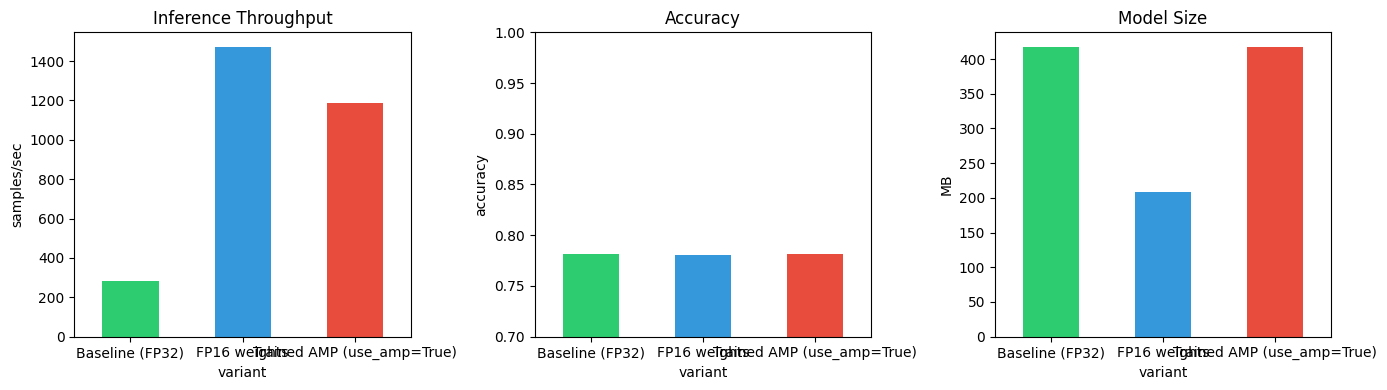


=== Speedup vs Baseline ===
FP16 weights: 5.22x speedup, Δaccuracy=-0.0010
Trained AMP (use_amp=True): 4.20x speedup, Δaccuracy=+0.0000


In [6]:
import matplotlib.pyplot as plt

# Stable ordering + nicer display names
preferred_order = ["baseline", "fp16_weights", "trained_amp", "amp_trained", "amp_autocast"]
present = results_df["variant"].tolist()
order = [v for v in preferred_order if v in present] + [v for v in present if v not in preferred_order]

display_name = {
    "baseline": "Baseline (FP32)",
    "fp16_weights": "FP16 weights",
    "trained_amp": "Trained AMP (use_amp=True)",
    "amp_trained": "Trained AMP (use_amp=True)",
    "amp_autocast": "Trained AMP (use_amp=True)",
}

variant_color = {
    "baseline": "#2ecc71",
    "fp16_weights": "#3498db",
    "trained_amp": "#e74c3c",
    "amp_trained": "#e74c3c",
    "amp_autocast": "#e74c3c",
}

plot_df = results_df.set_index("variant").loc[order]
colors = [variant_color.get(v, "#95a5a6") for v in plot_df.index]
xticklabels = [display_name.get(v, v) for v in plot_df.index]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Throughput
ax = axes[0]
plot_df["eval_samples_per_s"].plot(kind="bar", ax=ax, color=colors)
ax.set_title("Inference Throughput")
ax.set_ylabel("samples/sec")
ax.set_xticklabels(xticklabels, rotation=0)

# Accuracy
ax = axes[1]
plot_df["accuracy"].plot(kind="bar", ax=ax, color=colors)
ax.set_title("Accuracy")
ax.set_ylabel("accuracy")
ax.set_ylim(0.7, 1.0)
ax.set_xticklabels(xticklabels, rotation=0)

# Model Size
ax = axes[2]
plot_df["model_size_mb"].plot(kind="bar", ax=ax, color=colors)
ax.set_title("Model Size")
ax.set_ylabel("MB")
ax.set_xticklabels(xticklabels, rotation=0)

plt.tight_layout()
plt.show()

# Speedup summary
if len(plot_df) > 1 and "baseline" in plot_df.index:
    base = plot_df.loc["baseline"]
    print("\n=== Speedup vs Baseline ===")
    for variant, row in plot_df.iterrows():
        if variant == "baseline":
            continue
        speedup = row["eval_samples_per_s"] / base["eval_samples_per_s"]
        delta_acc = row["accuracy"] - base["accuracy"]
        print(f"{display_name.get(variant, variant)}: {speedup:.2f}x speedup, Δaccuracy={delta_acc:+.4f}")

In [7]:
results_df

,variant,model_size_mb,eval_wall_s,eval_samples_per_s,accuracy,f1_macro
0,baseline,417.658215,3.437209,282.205696,0.781443,0.769548
1,fp16_weights,208.833014,0.658638,1472.736709,0.780412,0.768758
2,amp_autocast,417.658215,0.817891,1185.977321,0.781443,0.780778


In [8]:
# Log summary to W&B
summary = {
    "baseline_train_wall_s": baseline_train_wall_s,
    "baseline_accuracy": baseline_metrics["accuracy"],
    "baseline_f1": baseline_metrics["f1_macro"],
    "baseline_throughput": baseline_timing["eval_samples_per_s"],
    "baseline_model_size": get_model_size_mb(trained_model_fp32),
}

if device.type == "cuda":
    summary.update({
        "fp16_accuracy": fp16_metrics["accuracy"],
        "fp16_throughput": fp16_timing["eval_samples_per_s"],
        "fp16_model_size": get_model_size_mb(fp16_model),
        "amp_train_wall_s": amp_train_wall_s,
        "amp_accuracy": amp_metrics["accuracy"],
        "amp_f1": amp_metrics["f1_macro"],
        "amp_throughput": amp_timing["eval_samples_per_s"],
        "amp_model_size": get_model_size_mb(trained_model_amp),
    })

wandb.log(summary)

# We'll upload the results_df (or plot_df) as a W&B Table for interactive dashboards

# Option 1: upload the underlying DataFrame as a W&B Table
# (works best if your DataFrame columns cover all metrics you'd like to compare)
table = wandb.Table(dataframe=results_df)

wandb.log({"variant_summary_table": table})

wandb.finish()

amp_accuracy,▁
amp_f1,▁
amp_model_size,▁
amp_throughput,▁
amp_train_wall_s,▁
baseline_accuracy,▁
baseline_f1,▁
baseline_model_size,▁
baseline_throughput,▁
baseline_train_wall_s,▁
+8,...
